In [1]:
import geopandas as gpd
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import os
import fnmatch
import mapclassify
from scipy.stats import pearsonr, spearmanr
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe
from tqdm import tqdm
import numpy as np

In [2]:
# Define paths
data = './data'
supply = os.path.join(data, 'original_data', 'supply_related')
demand = os.path.join(data, 'original_data', 'demand_related')

## Date Calculation

In [3]:
# Calculate focus date for confirmed case calculation
from_date = '2020-07-01'
to_date = '2021-12-31'

start_date = datetime.datetime.strptime(from_date,  "%Y-%m-%d")
end_date = datetime.datetime.strptime(to_date,  "%Y-%m-%d")

focus_date = []
focus_date_demand = []
delta = datetime.timedelta(days=1)
while start_date <= end_date:
    focus_date.append(start_date.strftime("%m/%d/%Y"))
    focus_date_demand.append(start_date.strftime("%Y-%m-%d"))
#     focus_date_demand.append(start_date.strftime("%m/%d/%Y"))
    start_date += delta
    
# Add 04/30/2020 to the focus date. 
focus_date_ = focus_date.copy()
focus_date_.insert(0, '06/30/2020')

In [4]:
focus_date

['07/01/2020',
 '07/02/2020',
 '07/03/2020',
 '07/04/2020',
 '07/05/2020',
 '07/06/2020',
 '07/07/2020',
 '07/08/2020',
 '07/09/2020',
 '07/10/2020',
 '07/11/2020',
 '07/12/2020',
 '07/13/2020',
 '07/14/2020',
 '07/15/2020',
 '07/16/2020',
 '07/17/2020',
 '07/18/2020',
 '07/19/2020',
 '07/20/2020',
 '07/21/2020',
 '07/22/2020',
 '07/23/2020',
 '07/24/2020',
 '07/25/2020',
 '07/26/2020',
 '07/27/2020',
 '07/28/2020',
 '07/29/2020',
 '07/30/2020',
 '07/31/2020',
 '08/01/2020',
 '08/02/2020',
 '08/03/2020',
 '08/04/2020',
 '08/05/2020',
 '08/06/2020',
 '08/07/2020',
 '08/08/2020',
 '08/09/2020',
 '08/10/2020',
 '08/11/2020',
 '08/12/2020',
 '08/13/2020',
 '08/14/2020',
 '08/15/2020',
 '08/16/2020',
 '08/17/2020',
 '08/18/2020',
 '08/19/2020',
 '08/20/2020',
 '08/21/2020',
 '08/22/2020',
 '08/23/2020',
 '08/24/2020',
 '08/25/2020',
 '08/26/2020',
 '08/27/2020',
 '08/28/2020',
 '08/29/2020',
 '08/30/2020',
 '08/31/2020',
 '09/01/2020',
 '09/02/2020',
 '09/03/2020',
 '09/04/2020',
 '09/05/20

In [5]:
# Make a dictionary that has keys as target date and values as the date that should be averaged. 
focus_date_dict = {}
time_delta = [3, 2, 1, 0, -1, -2, -3]

for idx, date in enumerate(focus_date):
    temp_list = []
    for delta in time_delta:
        temp_list.append(
            str(
                (datetime.datetime.strptime(focus_date[idx], "%m/%d/%Y") - datetime.timedelta(days=delta)
                ).strftime("%m/%d/%Y"))
        )
        
    focus_date_dict[date] = temp_list
    
# Manually enter the dates that would have missing values
focus_date_dict['07/01/2020'] = ['07/01/2020', '07/02/2020', '07/03/2020', '07/04/2020']
focus_date_dict['07/02/2020'] = ['07/01/2020', '07/02/2020', '07/03/2020', '07/04/2020', '07/05/2020']
focus_date_dict['07/03/2020'] = ['07/01/2020', '07/02/2020', '07/03/2020', '07/04/2020', '07/05/2020', '07/06/2020']
focus_date_dict['12/29/2021'] = ['12/26/2021', '12/27/2021', '12/28/2021', '12/29/2021', '12/30/2021', '12/31/2021']
focus_date_dict['12/30/2021'] = ['12/27/2021', '12/28/2021', '12/29/2021', '12/30/2021', '12/31/2021']
focus_date_dict['12/31/2021'] = ['12/28/2021', '12/29/2021', '12/30/2021', '12/31/2021']

In [6]:
# # Make a dictionary that has keys as target date and values as the date that should be averaged. 
# focus_date_dict = {}
# time_delta = list(range(0, -7, -1))

# for idx, date in enumerate(focus_date):  # Starts from 06/01/2020
#     temp_list = []
#     for delta in time_delta:
#         temp_list.append(
#             str(
#                 (datetime.datetime.strptime(focus_date[idx], "%m/%d/%Y") + datetime.timedelta(days=delta)
#                 ).strftime("%m/%d/%Y"))
#         )
        
#     focus_date_dict[date] = temp_list

# # Remove days in May from the dictionary, given that it is not the focus date of our analysis. 
# may_date = fnmatch.filter(focus_date_dict.keys(), '05/??/2020')

# for date in may_date:
#     del focus_date_dict[date]
    
# # focus_date_dict

## COVID Case and Death

In [7]:
tsa = pd.read_json('./data/original_data/tsa_county.json')
# tsa = tsa.set_index('County')
tsa['FIPS'] = tsa['FIPS'].astype(str)
tsa

,FIPS,TSA,County
0,48011,A,Armstrong
1,48045,A,Briscoe
2,48065,A,Carson
3,48075,A,Childress
4,48087,A,Collingsworth
...,...,...,...
249,48475,J,Ward
250,48495,J,Winkler
251,48109,I,Culberson
252,48141,I,El Paso


In [8]:
# Load daily confirmed case data
covid_case = pd.read_excel(os.path.join(demand, 'Texas COVID-19 New Confirmed Cases by County.xlsx'),
                           sheet_name='New Cases by County 2020',
                           header=2,
                           index_col=0)

covid_case = covid_case.loc['Anderson':'Zavala', focus_date]
covid_case.columns = covid_case.columns.astype(str)

# covid_case['case_sum'] = covid_case.apply(lambda x:x.sum(), axis=1)

rename_lookup = dict(zip(focus_date_demand, focus_date))
covid_case = covid_case.rename(columns=rename_lookup, errors='raise')
    
# covid_case = covid_case.reset_index()
# covid_case.to_csv('./data/plots/daily_covid_case.csv')
covid_case

,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,07/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
County,,,,,,,,,,,,,,,,,,,,,
Anderson,4.0,8.0,4.0,26.0,2.0,4.0,9.0,8.0,3.0,15.0,...,1.0,6.0,2.0,7.0,3.0,7.0,4.0,13.0,4.0,4.0
Andrews,2.0,4.0,2.0,1.0,0.0,9.0,3.0,6.0,10.0,8.0,...,3.0,10.0,5.0,0.0,0.0,0.0,0.0,16.0,27.0,16.0
Angelina,8.0,63.0,17.0,11.0,2.0,8.0,18.0,3.0,23.0,1.0,...,1.0,7.0,6.0,6.0,7.0,9.0,9.0,11.0,7.0,23.0
Aransas,4.0,4.0,2.0,1.0,4.0,3.0,2.0,1.0,4.0,6.0,...,0.0,2.0,1.0,5.0,2.0,1.0,9.0,0.0,1.0,4.0
Archer,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,2.0,...,1.0,6.0,3.0,2.0,2.0,3.0,11.0,3.0,2.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wood,1.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,1.0,...,3.0,3.0,2.0,8.0,1.0,9.0,1.0,6.0,1.0,2.0
Yoakum,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Young,3.0,2.0,0.0,1.0,0.0,1.0,2.0,3.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,8.0,1.0,1.0,3.0


In [9]:
# Loaded data is the accumulated death per county
covid_death = pd.read_excel(os.path.join(demand, 'Texas COVID-19 Fatality Count Data by County.xlsx'),
                             sheet_name='Fatalities by County 2020',
                             header=2,
                             index_col=0)

covid_death = covid_death.loc['Anderson':'Zavala', focus_date_]

# death_case = death_case.reset_index()
# death_case['death_sum'] = death_case['12/31/2021']
covid_death


# Calculate daily death from the accumulated value
daily_death = pd.DataFrame(index=covid_death.index, columns=focus_date_[1:])

for i, date in enumerate(focus_date_):
    if i != 0:
        daily_death[date] = covid_death[date] - covid_death[focus_date_[i -1]]

# Remove negative value of daily death. 
# Negative value has replaced with 0
for col in daily_death.columns:
    daily_death[col] = daily_death[col].mask(daily_death[col] < 0, 0)
        
daily_death

,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,07/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
County,,,,,,,,,,,,,,,,,,,,,
Anderson,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
Andrews,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Angelina,0,1,0,1,0,2,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
Aransas,0,0,0,0,1,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Archer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wood,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,1,0
Yoakum,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Young,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Overall COVID Stats

In [10]:
# Poplation from ACS data
pop = pd.read_csv(os.path.join(demand, 'ACSDT5Y2019.B01003_2022-02-21T221149', 'ACSDT5Y2019.B01003_data_with_overlays_2022-02-21T221145.csv'))
pop = pop[1:]
pop['FIPS'] = pop['GEO_ID'].apply(lambda x:x[9:14])
pop = pop.rename(columns={'B01003_001E': 'pop'})
pop['pop'] = pop['pop'].astype(int)
pop = pop.groupby(by='FIPS').sum()
pop = pop.reset_index()
pop = pop.merge(tsa, on='FIPS')
pop

,FIPS,pop,TSA,County
0,48001,57810,G,Anderson
1,48003,18036,J,Andrews
2,48005,87322,H,Angelina
3,48007,24462,U,Aransas
4,48009,8716,C,Archer
...,...,...,...,...
249,48499,44366,G,Wood
250,48501,8631,B,Yoakum
251,48503,18036,C,Young
252,48505,14304,T,Zapata


In [11]:
county = gpd.read_file(os.path.join(demand, 'tl_2021_48_county', 'tl_2021_48_county.shp'))
county = county[['NAME', 'GEOID', 'geometry']]
county.sort_values(by='NAME', inplace=True, ignore_index=True)
county = county.set_index('NAME')
county = county.merge(covid_case.apply(lambda x:x.sum(), axis=1).rename('case'), left_index=True, right_index=True)
county = county.merge(daily_death.apply(lambda x:x.sum(), axis=1).rename('death'), left_index=True, right_index=True)
county = county.reset_index()
county = county.merge(pop, left_on='GEOID', right_on='FIPS')
county = county.drop(columns=['FIPS'])
county['case_ratio'] = county['case'] / county['pop'] * 1000
county['death_ratio'] = county['death'] / county['pop'] * 1000
county['case_fatality'] = county['death'] / county['case'] * 1000
county = county.rename(columns={'index':'NAME'})
county = county.to_crs(epsg=3081)
county

,NAME,GEOID,geometry,case,death,pop,TSA,County,case_ratio,death_ratio,case_fatality
0,Anderson,48001,"POLYGON ((1440392.625 1070275.995, 1440394.136...",5204.0,207,57810,G,Anderson,90.019028,3.580695,39.777095
1,Andrews,48003,"POLYGON ((792219.493 1130103.506, 792219.283 1...",2462.0,65,18036,J,Andrews,136.504768,3.603903,26.401300
2,Angelina,48005,"POLYGON ((1527772.708 998471.159, 1527771.700 ...",6762.0,403,87322,H,Angelina,77.437530,4.615103,59.597752
3,Aransas,48007,"POLYGON ((1274596.986 661976.640, 1275197.203 ...",1856.0,68,24462,U,Aransas,75.872782,2.779822,36.637931
4,Archer,48009,"POLYGON ((1146052.762 1278817.953, 1146055.620...",1068.0,24,8716,C,Archer,122.533272,2.753557,22.471910
...,...,...,...,...,...,...,...,...,...,...,...
249,Wood,48499,"POLYGON ((1453300.416 1186211.472, 1453300.470...",3703.0,242,44366,G,Wood,83.464815,5.454627,65.352417
250,Yoakum,48501,"POLYGON ((758198.913 1216450.100, 758196.993 1...",708.0,36,8631,B,Yoakum,82.029892,4.171011,50.847458
251,Young,48503,"POLYGON ((1128414.929 1247487.578, 1128741.058...",2297.0,74,18036,C,Young,127.356398,4.102905,32.215934
252,Zapata,48505,"POLYGON ((1083961.136 569160.648, 1084088.878 ...",1640.0,45,14304,T,Zapata,114.653244,3.145973,27.439024


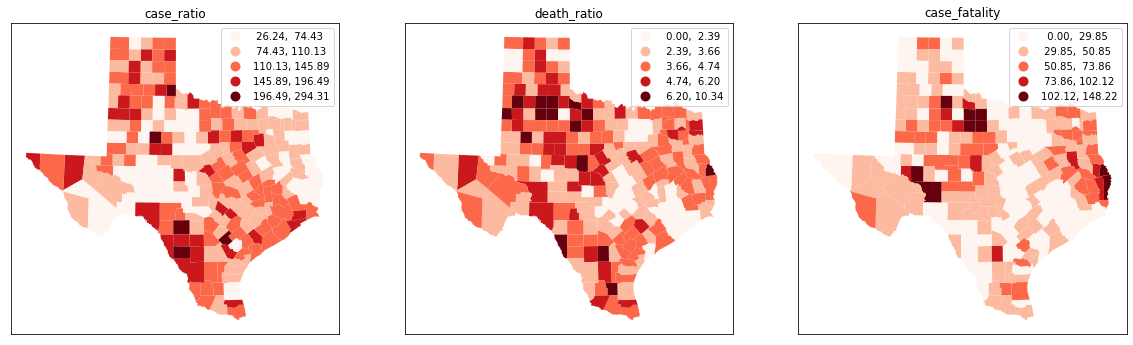

In [12]:
fig, axes = plt.subplots(1,3, figsize=(20, 15))

for idx, val in enumerate(['case_ratio', 'death_ratio', 'case_fatality']):
    county.plot(val, ax=axes[idx], scheme='FisherJenks', cmap='Reds', legend=True)
    
    # Decoration
    axes[idx].get_xaxis().set_visible(False)  # Remove ticks and labels
    axes[idx].get_yaxis().set_visible(False)  # Remove ticks and labels
    axes[idx].set_title(val)
    
plt.show()

## Study Area

In [13]:
hospitals = gpd.read_file(os.path.join(data, 'processed_data', 'input_files', 'hospital_geocode.json'))
hospitals

,HC_ID,Type,Zip,County,Staffed_Beds,ICU_Beds,FIPS,TSA,lat,lng,geometry
0,H000,Short Term Acute Care Hospital,75001,Dallas,32.0,4,48113,E,32.984766,-96.829405,POINT (1295826.606 1205448.145)
1,H001,Short Term Acute Care Hospital,75006,Dallas,NaN,0,48113,E,32.986187,-96.898161,POINT (1289408.831 1205423.487)
2,H002,Short Term Acute Care Hospital,75039,Dallas,80.0,8,48113,E,32.902051,-96.957361,POINT (1284142.861 1195958.149)
3,H003,Psychiatric Hospital,75042,Dallas,72.0,0,48113,E,32.919345,-96.661640,POINT (1311693.519 1198668.471)
4,H004,Psychiatric Hospital,75042,Dallas,NaN,0,48113,E,32.913402,-96.670117,POINT (1310922.134 1197986.972)
...,...,...,...,...,...,...,...,...,...,...,...
647,H647,Department of Defense Hospital,79920,El Paso,209.0,2,48141,I,31.821613,-106.462489,POINT (389774.009 1090294.335)
648,H648,Short Term Acute Care Hospital,79928,El Paso,8.0,1,48141,I,31.681737,-106.208044,POINT (412906.494 1073465.365)
649,H649,Rehabilitation Hospital,79936,El Paso,41.0,0,48141,I,31.732221,-106.303061,POINT (404248.394 1079550.379)
650,H650,Short Term Acute Care Hospital,79936,El Paso,40.0,7,48141,I,31.734983,-106.300487,POINT (404508.894 1079841.684)


<AxesSubplot:>

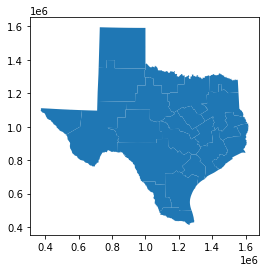

In [14]:
county_boundary = gpd.read_file('./data/plots/ICU_access_county.shp')
county_boundary.set_index('index', inplace=True)
county_boundary = county_boundary.to_crs(epsg=3081)
county_boundary = county_boundary[['geometry']]
county_boundary

tsa_boundary = pd.read_json('./data/original_data/tsa_county.json')
tsa_boundary['FIPS'] = tsa_boundary['FIPS'].astype(str)
tsa_boundary.set_index('FIPS', inplace=True)
tsa_boundary = county_boundary.merge(tsa_boundary, left_index=True, right_index=True)
tsa_boundary = tsa_boundary.dissolve(by='TSA')
tsa_boundary = tsa_boundary.drop(columns='County')
tsa_boundary['geometry'] = tsa_boundary['geometry'].simplify(0.01)
tsa_boundary.plot()

In [15]:
# Define map classification - power of 10
map_class = [10**num for num in range(1, 7)]
print(map_class)

for idx, cls in enumerate(map_class):
    if idx != 0:
        temp_count = county.loc[(county['case'] < cls) & (county['case'] > map_class[idx-1])].shape[0]
        print(cls, temp_count)
    elif idx == 0:
        temp_count = county.loc[(county['case'] < cls) & (county['case'] > 0)].shape[0]
        print(cls, temp_count)


[10, 100, 1000, 10000, 100000, 1000000]
10 1
100 14
1000 71
10000 128
100000 33
1000000 7


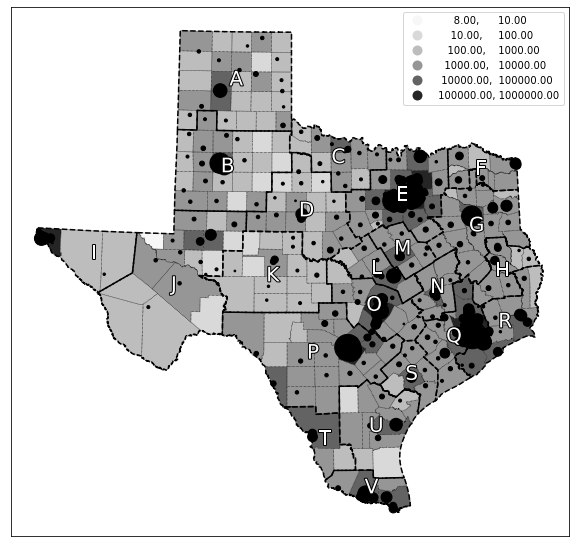

In [16]:
fig, ax = plt.subplots(figsize=(10,10))

color_brewer = ['#f7f7f7','#d9d9d9','#bdbdbd','#969696','#636363','#252525']  # Hex color codes were grabbed from ColorBrewer
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=6)  # Create a colormap instance with the hex codes
cm

hospitals['markersize'] = hospitals.apply(lambda x:x['ICU_Beds'] * 3 , axis=1)

hospitals.plot(markersize='markersize', ax=ax, zorder=2, color='black', legend=True)
# county.plot('case', ax=ax, scheme='FisherJenks', k=7,zorder=1, cmap=cm, legend=True)
county.plot('case', 
            ax=ax, 
            scheme='user_defined', # To use different (not predefined) bins, we need to call it as 'user_defined'
            classification_kwds={'bins':map_class}, # then speicfy class here. 
            k=7,
            zorder=1, cmap=cm, legend=True)

county.boundary.plot(color='black', 
                     linewidth=0.5, 
                     linestyle='dotted', 
                     ax=ax
                    )

tsa_boundary.boundary.plot(color='black', 
                     linewidth=1.5, 
                     linestyle='dashed', 
                     ax=ax)

for idx, row in tsa_boundary.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
    ax.text(s=idx, # String to be displayed; TSA name
            x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
            y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label
            fontsize=20, 
            color='white',
            ha='center', # Horizontal align
            va='center', # Vertical align
            path_effects=[pe.withStroke(linewidth=2, foreground="black")] # This will create boundary of text
           )

ax.get_xaxis().set_visible(False)  # Remove ticks and labels
ax.get_yaxis().set_visible(False)


## Trend Plot

In [17]:
ave_case = covid_case.copy(deep=True)
ave_death = daily_death.copy(deep=True)

for idx, val in focus_date_dict.items():
    ave_death[idx] = daily_death[val].mean(axis=1)
    ave_case[idx] = covid_case[val].mean(axis=1)
    
ave_case = ave_case.reset_index()
ave_death = ave_death.reset_index()

In [18]:
def standardize(ary):
    ary_ = ary.copy()
    ary_ = ary_.astype('float64')
    
    for idx, val in enumerate(ary):
        ary_[idx] = (val - ary.mean()) / ary.std()
        
    return ary_

def normalize(ary):
    ary_ = ary.copy()
    ary_ = ary_.astype('float64')
    
    for idx, val in enumerate(ary):
        ary_[idx] = (val - ary.min()) / (ary.max() - ary.min())
        
    return ary_

In [19]:
trend = pd.DataFrame(index=focus_date_dict.keys())
trend['case'] = ave_case[focus_date_dict.keys()].sum()
trend['death'] = ave_death[focus_date_dict.keys()].sum()
trend['ratio'] = trend['death'] / trend['case'] * 1000
trend['case_norm'] = normalize(trend['case'])
trend['death_norm'] = normalize(trend['death'])
trend['ratio_norm'] = normalize(trend['ratio'])
trend

,case,death,ratio,case_norm,death_norm,ratio_norm
07/01/2020,5615.500000,126.250000,22.482415,0.267093,0.324102,0.336317
07/02/2020,5938.400000,127.400000,21.453590,0.284585,0.327545,0.316175
07/03/2020,6187.666667,131.166667,21.198082,0.298088,0.338822,0.311173
07/04/2020,6402.571429,135.857143,21.219153,0.309730,0.352866,0.311585
07/05/2020,6897.571429,150.857143,21.871052,0.336545,0.397776,0.324348
...,...,...,...,...,...,...
12/27/2021,11614.714286,63.428571,5.461053,0.592080,0.136014,0.003072
12/28/2021,11767.857143,64.142857,5.450683,0.600376,0.138152,0.002869
12/29/2021,11601.166667,67.333333,5.804014,0.591346,0.147705,0.009787
12/30/2021,11895.200000,67.000000,5.632524,0.607274,0.146707,0.006429


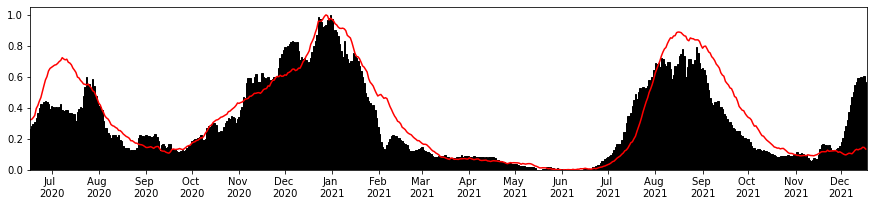

In [20]:
period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]

fig, ax = plt.subplots(figsize=(15, 3))

# ax.plot(trend['case_norm'], color='black')
ax.bar(trend.index, trend['case_norm'], width=1.0, facecolor='black', edgecolor='black')
ax.plot(trend['death_norm'], color='red')
ax.set_xlim(0, len(focus_date))
# ax.plot(trend['ratio_norm'])

# ax.set_xticks([date for date in focus_date if date[3:5] == '15']) # The locations that ticks will be displayed.
ax.set_xticks([focus_date.index(val) for val in period])
ax.set_xticklabels([datetime.datetime.strptime(val, '%m/%d/%Y').strftime('%b \n%Y') for val in period]
)
plt.show()

# COVID-19 Census per TSA

In [21]:
tsa

,FIPS,TSA,County
0,48011,A,Armstrong
1,48045,A,Briscoe
2,48065,A,Carson
3,48075,A,Childress
4,48087,A,Collingsworth
...,...,...,...
249,48475,J,Ward
250,48495,J,Winkler
251,48109,I,Culberson
252,48141,I,El Paso


In [22]:
ave_case

,County,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
0,Anderson,10.50,8.8,8.000000,8.142857,8.714286,8.000000,9.571429,14.285714,61.857143,...,3.857143,3.857143,4.285714,4.285714,6.000000,5.714286,6.000000,5.833333,6.4,6.25
1,Andrews,2.25,1.8,3.000000,3.000000,3.571429,4.428571,5.285714,5.428571,5.428571,...,3.428571,3.285714,3.285714,2.571429,4.428571,6.857143,8.428571,9.833333,11.8,14.75
2,Angelina,24.75,20.2,18.166667,18.142857,17.428571,11.714286,9.428571,11.285714,12.857143,...,5.000000,6.000000,6.428571,6.428571,7.857143,7.857143,10.285714,11.000000,11.8,12.50
3,Aransas,2.75,3.0,3.000000,2.857143,2.428571,2.428571,3.000000,3.571429,3.142857,...,2.285714,2.285714,2.285714,2.857143,2.857143,2.714286,3.142857,2.833333,3.0,3.50
4,Archer,0.50,0.4,0.500000,0.571429,0.571429,0.571429,0.857143,0.571429,0.571429,...,3.000000,2.857143,3.285714,4.000000,4.285714,3.714286,4.857143,5.333333,6.0,6.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,Wood,0.50,0.6,0.500000,0.714286,0.857143,0.857143,1.000000,0.857143,0.714286,...,6.000000,5.857143,6.857143,3.857143,4.285714,4.000000,4.000000,3.333333,3.8,2.50
250,Yoakum,0.75,0.8,0.666667,0.714286,0.285714,0.285714,0.285714,0.285714,0.142857,...,0.142857,0.142857,0.142857,0.285714,0.428571,0.428571,0.285714,0.333333,0.4,0.50
251,Young,1.50,1.2,1.166667,1.285714,1.285714,1.142857,1.285714,1.428571,1.571429,...,0.714286,0.714286,0.857143,1.714286,1.714286,1.857143,2.142857,2.333333,2.8,3.25
252,Zapata,0.50,0.8,0.833333,0.857143,0.714286,1.000000,2.142857,4.000000,5.000000,...,0.571429,0.714286,0.571429,1.428571,1.428571,1.428571,1.285714,1.333333,1.2,1.50


In [23]:
ave_case_tsa = ave_case.merge(tsa, left_index=True, right_index=True)
ave_case_tsa.drop(columns=['FIPS'], inplace=True)
ave_case_tsa = ave_case_tsa.groupby('TSA').sum()
# ave_case_tsa = tsa_boundary.merge(ave_case_tsa, left_index=True, right_index=True)
ave_case_tsa

,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,07/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
TSA,,,,,,,,,,,,,,,,,,,,,
A,727.75,744.8,780.166667,804.857143,875.571429,847.142857,852.428571,871.428571,896.428571,955.285714,...,964.571429,1023.714286,1155.000000,1203.000000,1239.857143,1244.000000,1249.142857,1198.000000,1247.4,1145.00
B,227.75,230.4,246.833333,260.714286,263.142857,302.000000,328.857143,359.857143,359.857143,366.428571,...,376.428571,384.000000,414.714286,462.142857,498.571429,539.857143,529.142857,520.833333,553.4,555.25
C,660.75,738.6,774.833333,781.714286,842.428571,948.857143,1110.428571,1183.714286,1124.714286,1167.714286,...,711.714286,740.000000,824.714286,913.714286,958.000000,1048.000000,1072.571429,1047.833333,1122.4,1078.25
D,156.50,173.4,215.500000,253.000000,278.857143,295.714286,339.714286,383.857143,399.857143,408.571429,...,418.142857,402.428571,421.142857,468.571429,488.571429,529.285714,549.714286,553.166667,586.6,590.50
E,325.75,369.2,404.000000,423.714286,467.571429,518.714286,486.857143,522.714286,513.857143,522.571429,...,900.000000,957.285714,1031.714286,1097.428571,1160.000000,1128.000000,1165.714286,1180.333333,1215.8,1155.25
F,30.25,31.2,38.666667,45.428571,53.000000,58.285714,64.428571,74.714286,84.000000,90.857143,...,47.714286,52.714286,57.714286,62.428571,65.428571,66.000000,69.142857,69.000000,71.2,69.25
G,1729.25,1833.6,1774.333333,1787.142857,2003.285714,2258.571429,2340.428571,2511.571429,2455.714286,2635.142857,...,3795.285714,4076.714286,4309.428571,4280.714286,4328.285714,4167.000000,4058.285714,4018.666667,3972.6,3594.50
H,47.00,43.6,47.166667,49.428571,49.142857,59.142857,50.714286,52.428571,60.428571,56.571429,...,24.285714,26.000000,33.000000,32.857143,39.285714,39.142857,40.000000,39.333333,42.4,39.00
I,3.50,3.2,3.500000,4.285714,3.714286,4.285714,5.285714,7.571429,9.000000,9.571429,...,2.428571,2.428571,2.571429,4.142857,4.285714,4.428571,4.428571,4.833333,5.4,6.00


In [24]:
ave_death_tsa = ave_death.merge(tsa, left_index=True, right_index=True)
ave_death_tsa.drop(columns=['FIPS'], inplace=True)
ave_death_tsa = ave_death_tsa.groupby('TSA').sum()
# ave_death_tsa = tsa_boundary.merge(ave_death_tsa, left_index=True, right_index=True)
ave_death_tsa

,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,07/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
TSA,,,,,,,,,,,,,,,,,,,,,
A,23.50,23.4,23.666667,22.285714,24.142857,24.428571,26.428571,27.428571,28.142857,30.714286,...,5.142857,5.000000,5.714286,6.000000,5.857143,6.142857,5.714286,5.833333,6.2,5.25
B,15.00,14.4,13.666667,15.142857,16.285714,16.285714,16.857143,16.428571,18.571429,20.285714,...,2.857143,3.571429,4.142857,4.142857,4.000000,3.714286,4.285714,3.833333,3.6,3.25
C,9.00,8.8,8.833333,9.428571,10.000000,10.571429,10.714286,10.857143,11.428571,11.857143,...,3.285714,3.428571,4.000000,4.428571,4.714286,5.571429,5.857143,6.000000,6.6,7.00
D,7.25,6.4,6.500000,6.428571,6.428571,5.714286,6.142857,6.571429,8.285714,9.000000,...,10.000000,10.571429,10.285714,10.000000,8.857143,9.142857,8.714286,8.833333,8.8,8.75
E,5.00,4.8,5.333333,6.000000,6.000000,6.000000,5.428571,6.000000,6.714286,6.857143,...,2.571429,2.571429,3.000000,3.142857,3.285714,3.428571,4.142857,4.666667,4.8,4.50
F,1.50,1.4,1.333333,1.428571,1.285714,2.000000,2.000000,1.714286,2.000000,3.000000,...,0.714286,0.714286,0.714286,0.714286,0.428571,0.571429,0.857143,0.833333,1.0,1.00
G,37.00,39.2,41.333333,44.428571,51.571429,55.000000,59.571429,62.714286,65.142857,68.428571,...,7.428571,7.857143,9.000000,8.714286,9.571429,10.000000,10.285714,11.000000,10.8,9.25
H,0.25,0.4,0.666667,0.571429,0.571429,0.857143,1.000000,1.428571,1.714286,1.714286,...,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.285714,0.333333,0.2,0.25
I,0.25,0.2,0.166667,0.142857,0.142857,0.285714,0.428571,0.285714,0.285714,0.285714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00


In [25]:
ave_case

,County,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
0,Anderson,10.50,8.8,8.000000,8.142857,8.714286,8.000000,9.571429,14.285714,61.857143,...,3.857143,3.857143,4.285714,4.285714,6.000000,5.714286,6.000000,5.833333,6.4,6.25
1,Andrews,2.25,1.8,3.000000,3.000000,3.571429,4.428571,5.285714,5.428571,5.428571,...,3.428571,3.285714,3.285714,2.571429,4.428571,6.857143,8.428571,9.833333,11.8,14.75
2,Angelina,24.75,20.2,18.166667,18.142857,17.428571,11.714286,9.428571,11.285714,12.857143,...,5.000000,6.000000,6.428571,6.428571,7.857143,7.857143,10.285714,11.000000,11.8,12.50
3,Aransas,2.75,3.0,3.000000,2.857143,2.428571,2.428571,3.000000,3.571429,3.142857,...,2.285714,2.285714,2.285714,2.857143,2.857143,2.714286,3.142857,2.833333,3.0,3.50
4,Archer,0.50,0.4,0.500000,0.571429,0.571429,0.571429,0.857143,0.571429,0.571429,...,3.000000,2.857143,3.285714,4.000000,4.285714,3.714286,4.857143,5.333333,6.0,6.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,Wood,0.50,0.6,0.500000,0.714286,0.857143,0.857143,1.000000,0.857143,0.714286,...,6.000000,5.857143,6.857143,3.857143,4.285714,4.000000,4.000000,3.333333,3.8,2.50
250,Yoakum,0.75,0.8,0.666667,0.714286,0.285714,0.285714,0.285714,0.285714,0.142857,...,0.142857,0.142857,0.142857,0.285714,0.428571,0.428571,0.285714,0.333333,0.4,0.50
251,Young,1.50,1.2,1.166667,1.285714,1.285714,1.142857,1.285714,1.428571,1.571429,...,0.714286,0.714286,0.857143,1.714286,1.714286,1.857143,2.142857,2.333333,2.8,3.25
252,Zapata,0.50,0.8,0.833333,0.857143,0.714286,1.000000,2.142857,4.000000,5.000000,...,0.571429,0.714286,0.571429,1.428571,1.428571,1.428571,1.285714,1.333333,1.2,1.50


In [26]:
icu_empty_ratio = pd.read_csv(os.path.join(data, 'processed_data', 'input_files', 'ICU_beds_available_ratio.csv'))
icu_empty_ratio = icu_empty_ratio.set_index('Unnamed: 0')
icu_empty_ratio = icu_empty_ratio[focus_date]
icu_empty_ratio

,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,07/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
A,0.264151,0.260786,0.256238,0.256262,0.256783,0.261419,0.264535,0.260488,0.256133,0.248269,...,0.079110,0.081352,0.086207,0.087331,0.091352,0.085749,0.081535,0.080668,0.079602,0.066946
B,0.176322,0.167227,0.154167,0.146077,0.144407,0.143339,0.129958,0.119266,0.120789,0.120423,...,0.090835,0.082651,0.077176,0.069959,0.059701,0.047225,0.050654,0.048250,0.048152,0.044199
C,0.322188,0.316109,0.310769,0.304348,0.304075,0.309375,0.316456,0.321543,0.336570,0.339683,...,0.037975,0.025478,0.037037,0.066265,0.063953,0.072222,0.064865,0.074534,0.087591,0.073394
D,0.276423,0.281501,0.292308,0.298030,0.309633,0.312644,0.308068,0.290640,0.304348,0.301703,...,0.081851,0.088339,0.083916,0.071429,0.066445,0.055738,0.039867,0.026923,0.013699,0.011429
E,0.215852,0.215635,0.209944,0.198948,0.193168,0.187249,0.182183,0.176406,0.169009,0.166019,...,0.072909,0.072154,0.067877,0.065986,0.063651,0.060885,0.056968,0.055642,0.053312,0.051334
F,0.627689,0.625926,0.628571,0.632447,0.624658,0.615455,0.604714,0.595303,0.586703,0.578853,...,0.204225,0.230588,0.217494,0.202410,0.217184,0.217890,0.199105,0.189258,0.169184,0.180812
G,0.282189,0.282511,0.289308,0.291048,0.294647,0.292322,0.288470,0.278300,0.273336,0.260792,...,0.135796,0.134555,0.132878,0.130915,0.128219,0.120400,0.114076,0.107599,0.102174,0.096223
H,0.142857,0.142857,0.138716,0.138716,0.128364,0.122153,0.136646,0.144928,0.153209,0.161491,...,0.115646,0.110000,0.120915,0.147436,0.152104,0.143813,0.139373,0.135802,0.130000,0.103448
I,0.164598,0.170889,0.174705,0.172973,0.176375,0.169740,0.155795,0.145464,0.135121,0.126677,...,0.017732,0.015866,0.012218,0.010437,0.008517,0.008052,0.007081,0.007075,0.007047,0.007018


[0, 106, 198, 288, 379, 471, 548]


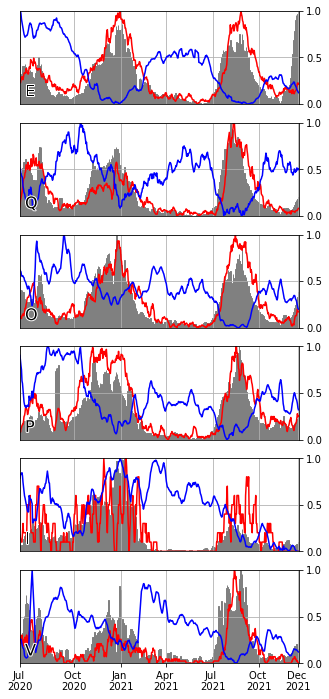

In [27]:
period_index = []
plot_period = ['07/01/2020', '10/15/2020', '01/15/2021', '04/15/2021', '07/15/2021', '10/15/2021', '12/31/2021']
for val in plot_period:
    
    period_index.append(focus_date.index(val))

print(period_index)

fig, axes = plt.subplots(6, 1, figsize=(5, 12))

focus_tsa = ['E', 'Q', 'O', 'P', 'I', 'V']
for t_idx, t_tsa in enumerate(focus_tsa):
    axes[t_idx].bar(ave_case_tsa.columns, normalize(ave_case_tsa.loc[t_tsa]), width=1.0, facecolor='grey', edgecolor='grey')
    
    normalize(ave_death_tsa.loc[t_tsa]).plot(ax=axes[t_idx], color='red')
    normalize(icu_empty_ratio.loc[t_tsa]).plot(ax=axes[t_idx], color='blue')
    
    
    axes[t_idx].text(s=f'{t_tsa}', # String to be displayed; TSA name,
                     x=10, 
                     y=0.05, 
                     fontsize=16, 
                     ha='left', 
                     va='bottom', 
                     path_effects=[pe.withStroke(linewidth=2, foreground="white")]
                    )

    axes[t_idx].set_xlim(0, len(focus_date))
    axes[t_idx].set_ylim(0, 1)
    axes[t_idx].grid(which='both')
    axes[t_idx].set_xticks(period_index)
    axes[t_idx].set_yticks([0, 0.5, 1])
    axes[t_idx].yaxis.tick_right()
    
    if t_idx + 1  < len(focus_tsa):
        axes[t_idx].tick_params(axis='x', which='both', labelbottom=False, bottom=False)   
    else:
        axes[t_idx].set_xticklabels([datetime.datetime.strptime(val, '%m/%d/%Y').strftime('%b \n%Y') for val in plot_period])
    
plt.show()

[0, 106, 198, 288, 379, 471, 548]


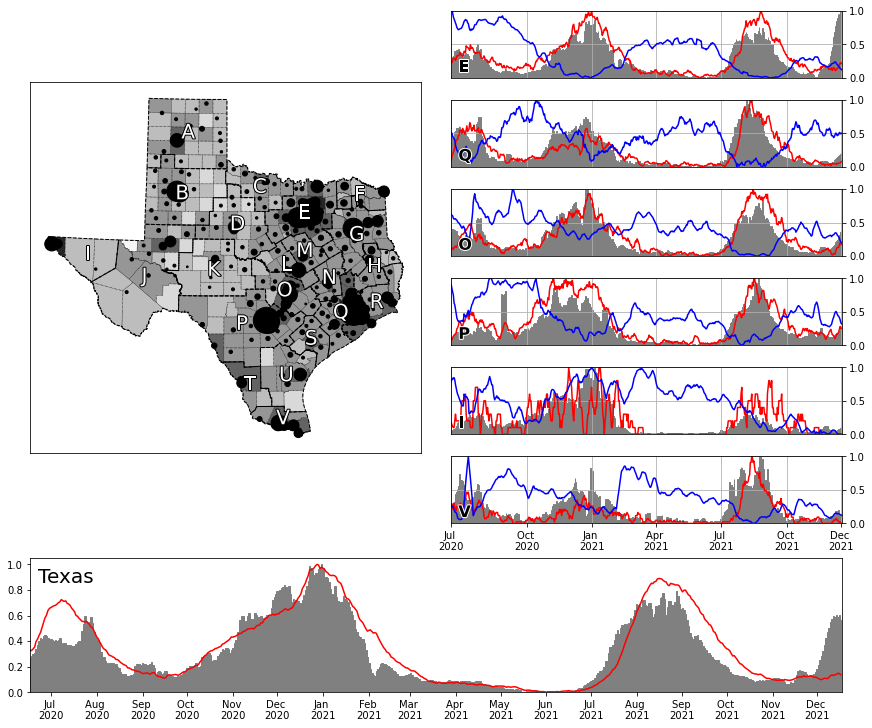

In [28]:
# https://matplotlib.org/stable/tutorials/intermediate/arranging_axes.html
gs_kw = dict(width_ratios=[1, 1], height_ratios=[1, 1, 1, 1, 1, 1, 2])
fig, axd = plt.subplot_mosaic([['left', 'right_1'], 
                               ['left', 'right_2'], 
                               ['left', 'right_3'], 
                               ['left', 'right_4'],
                               ['left', 'right_5'],
                               ['left', 'right_6'],
                               ['bottom', 'bottom']
                              ],
                              gridspec_kw=gs_kw, 
                              figsize=(12, 10),
                              constrained_layout=True
                             )



## Plot Texas on the left handed side
color_brewer = ['#f7f7f7','#d9d9d9','#bdbdbd','#969696','#636363','#252525']  # Hex color codes were grabbed from ColorBrewer
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=6)  # Create a colormap instance with the hex codes
cm

hospitals['markersize'] = hospitals.apply(lambda x:x['ICU_Beds'] * 3 , axis=1)

hospitals.plot(markersize='markersize', ax=axd['left'], zorder=2, color='black', legend=True)
county.plot('case', 
            ax=axd['left'], 
            scheme='user_defined', # To use different (not predefined) bins, we need to call it as 'user_defined'
            classification_kwds={'bins':map_class}, # then speicfy class here. 
            k=7,
            zorder=1, 
            cmap=cm, 
#             legend=True
           )

county.boundary.plot(color='black', 
                     linewidth=0.5, 
                     linestyle='dotted', 
                     ax=axd['left']
                    )

tsa_boundary.boundary.plot(color='black', 
                           linewidth=1, 
                           linestyle='dashed', 
                           ax=axd['left']
                          )

for idx, row in tsa_boundary.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
    axd['left'].text(s=idx, # String to be displayed; TSA name
                     x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
                     y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label            
                     fontsize=20, 
                     color='white',
                     ha='center', # Horizontal align
                     va='center', # Vertical align
                     path_effects=[pe.withStroke(linewidth=2, foreground="black")] # This will create boundary of text
                    )

axd['left'].get_xaxis().set_visible(False)  # Remove ticks and labels
axd['left'].get_yaxis().set_visible(False)

## Plot COVID-trend per TSA on the right handed-side
period_index = []
plot_period = ['07/01/2020', '10/15/2020', '01/15/2021', '04/15/2021', '07/15/2021', '10/15/2021', '12/31/2021']
for val in plot_period:
    period_index.append(focus_date.index(val))

print(period_index)

focus_tsa = ['E', 'Q', 'O', 'P', 'I', 'V']
for t_idx, t_tsa in enumerate(focus_tsa, start=1):
    axd[f'right_{t_idx}'].bar(ave_case_tsa.columns, normalize(ave_case_tsa.loc[t_tsa]), width=1.0, facecolor='grey', edgecolor='grey')
    
    normalize(ave_death_tsa.loc[t_tsa]).plot(ax=axd[f'right_{t_idx}'], color='red')
    normalize(icu_empty_ratio.loc[t_tsa]).plot(ax=axd[f'right_{t_idx}'], color='blue')
    
    
    axd[f'right_{t_idx}'].text(s=f'{t_tsa}', # String to be displayed; TSA name,
                               x=10, 
                               y=0.05, 
                               fontsize=16, 
                               ha='left', 
                               va='bottom', 
                               weight='bold',
                               path_effects=[pe.withStroke(linewidth=2, foreground="white")]
                              )

    axd[f'right_{t_idx}'].set_xlim(0, len(focus_date))
    axd[f'right_{t_idx}'].set_ylim(0, 1)
    axd[f'right_{t_idx}'].grid(which='both')
    axd[f'right_{t_idx}'].set_xticks(period_index)
    axd[f'right_{t_idx}'].set_yticks([0, 0.5, 1])
    axd[f'right_{t_idx}'].yaxis.tick_right()
    
    if t_idx < len(focus_tsa):
        axd[f'right_{t_idx}'].tick_params(axis='x', which='both', labelbottom=False, bottom=False)   
    else:
        axd[f'right_{t_idx}'].set_xticklabels([datetime.datetime.strptime(val, '%m/%d/%Y').strftime('%b \n%Y') for val in plot_period])
    
# COVID-19 trend for the entire state
period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]


# ax.plot(trend['case_norm'], color='black')
axd['bottom'].bar(trend.index, trend['case_norm'], width=1.0, facecolor='grey', edgecolor='grey')
axd['bottom'].plot(trend['death_norm'], color='red')
axd['bottom'].set_xlim(0, len(focus_date))

axd['bottom'].set_xticks([focus_date.index(val) for val in period])
axd['bottom'].set_xticklabels([datetime.datetime.strptime(val, '%m/%d/%Y').strftime('%b \n%Y') for val in period])
axd['bottom'].text(s='Texas', 
                   x= 5,
                   y= 0.9,
                   color='Black',
                   ha='left',
                   va='center',
                   fontsize=20
#                    path_effects=[pe.withStroke(linewidth=2, foreground="black")] # This will create boundary of text
                  )

plt.show()


## Plot Temporal Changes of Accessibility Measures

In [29]:
access = gpd.read_file('./data/plots/ICU_access_tract.shp')
access_val = access[focus_date_dict.keys()].values.reshape(-1)
access_val[access_val>1] = 1 # Accessibiltiy more than 1 is unnecessary
map_class_acc = mapclassify.NaturalBreaks(access_val, k=7)
print(map_class_acc.bins)
map_class_acc

[0.02056396 0.05744243 0.12169651 0.23616165 0.43601246 0.74311586
 1.        ]


NaturalBreaks         

  Interval       Count
----------------------
[0.00, 0.02] | 1987602
(0.02, 0.06] |  604021
(0.06, 0.12] |  210545
(0.12, 0.24] |   58120
(0.24, 0.44] |   20268
(0.44, 0.74] |    6540
(0.74, 1.00] |    3389

07/15/2020
08/15/2020
09/15/2020
10/15/2020
11/15/2020
12/15/2020
01/15/2021
02/15/2021
03/15/2021
04/15/2021
05/15/2021
06/15/2021
07/15/2021
08/15/2021
09/15/2021
10/15/2021
11/15/2021
12/15/2021


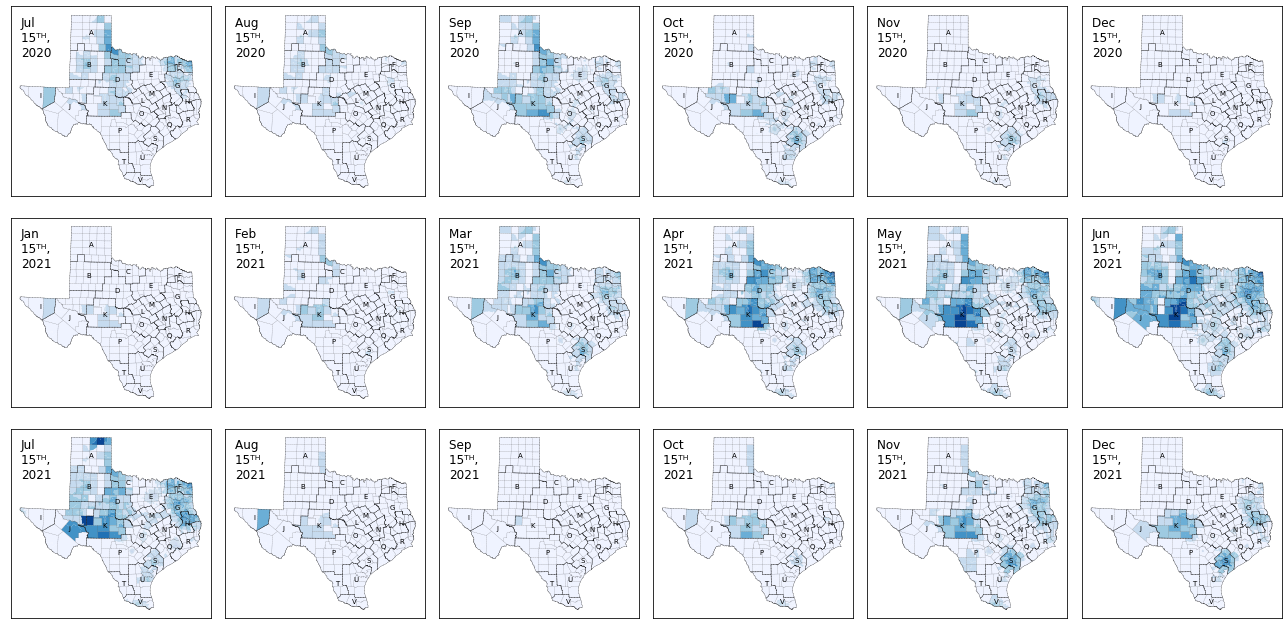

In [30]:
period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]
# Define color map
color_brewer = ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#084594']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=7)

fig, axes = plt.subplots(3, 6, figsize=(18,9))
ax = axes.reshape(-1)
for idx, m in enumerate(period):
    print(m)
    access.plot(column=m, 
            ax = ax[idx],
            cmap=cm,
            scheme='user_defined',
            classification_kwds={'bins':map_class_acc.bins} # then speicfy class here.
           )
    tsa_boundary.boundary.plot(ax=ax[idx], lw=0.3, color='black', linestyle='dashed')
    county_boundary.boundary.plot(ax=ax[idx], lw=0.15, color='black', linestyle='dotted')
    
    for idx_1, row in tsa_boundary.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
        ax[idx].text(s=idx_1, # String to be displayed; TSA name
                     x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
                     y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label            
                     fontsize=7, 
                     color='black',
                     ha='center', # Horizontal align
                     va='center', # Vertical align
#                      path_effects=[pe.withStroke(linewidth=1, foreground="white")] # This will create boundary of text
                    )
    
    
    month_text = datetime.datetime.strptime(m, '%m/%d/%Y')
    month_text = month_text.strftime('%b \n15ᵀᴴ, \n%Y')
    ax[idx].text(0.05, 0.95, s=month_text, fontsize=12, ha='left', va='top', transform=ax[idx].transAxes)
    ax[idx].get_xaxis().set_visible(False)
    ax[idx].get_yaxis().set_visible(False)
    
plt.tight_layout() # Will shrink empty area
plt.show()

## Temporal Changes of Mortality rate

In [54]:
ave_mortality = ave_death.copy(deep=True)

for date_ in focus_date:
    ave_mortality[date_] = ave_death[date_] / county['pop'] * 100000
    
ave_mortality

ave_mortality = ave_mortality.merge(county[['NAME', 'geometry']], left_on='County', right_on='NAME')
ave_mortality = gpd.GeoDataFrame(ave_mortality)
ave_mortality = ave_mortality.drop(columns=['County'])
ave_mortality = ave_mortality.to_crs(epsg=3081)
ave_mortality.head(3)

,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,07/10/2020,...,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,NAME,geometry
0,0.432451,0.345961,0.288301,0.247115,0.000000,0.000000,0.000000,0.000000,0.000000,0.247115,...,0.494230,0.741345,0.741345,0.494230,0.494230,0.576602,0.345961,0.432451,Anderson,"POLYGON ((1440392.625 1070275.995, 1440394.136..."
1,0.000000,1.108893,0.924078,0.792067,0.792067,0.792067,0.792067,0.792067,0.000000,0.000000,...,0.000000,0.792067,0.792067,0.792067,0.792067,0.924078,1.108893,1.386117,Andrews,"POLYGON ((792219.493 1130103.506, 792219.283 1..."
2,0.572593,0.458075,0.763458,0.654392,0.654392,0.490794,0.654392,0.654392,0.654392,0.654392,...,0.163598,0.163598,0.163598,0.163598,0.163598,0.190864,0.229037,0.286297,Angelina,"POLYGON ((1527772.708 998471.159, 1527771.700 ..."
3,0.000000,0.817595,0.681329,1.751989,2.335985,2.335985,2.335985,2.335985,1.751989,1.751989,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Aransas,"POLYGON ((1274596.986 661976.640, 1275197.203 ..."
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Archer,"POLYGON ((1146052.762 1278817.953, 1146055.620..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.643994,0.965991,0.643994,0.965991,0.643994,0.751326,0.901591,1.126989,Wood,"POLYGON ((1453300.416 1186211.472, 1453300.470..."
250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.655163,1.931024,2.317229,2.896536,Yoakum,"POLYGON ((758198.913 1216450.100, 758196.993 1..."
251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Young,"POLYGON ((1128414.929 1247487.578, 1128741.058..."
252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Zapata,"POLYGON ((1083961.136 569160.648, 1084088.878 ..."


In [55]:
ave_mortality_val = ave_mortality[focus_date_dict.keys()].values.reshape(-1)
# map_class_mortality = mapclassify.NaturalBreaks(ave_mortality_val, k=9)
map_class_mortality = mapclassify.NaturalBreaks(ave_mortality_val, k=7)
print(map_class_mortality.bins)
map_class_mortality

[  0.90430482   3.07371983   7.8235018   20.2251736   46.60918201
  84.36981194 141.52355551]


NaturalBreaks            

    Interval        Count
-------------------------
[  0.00,   0.90] | 106143
(  0.90,   3.07] |  25341
(  3.07,   7.82] |   6536
(  7.82,  20.23] |   1049
( 20.23,  46.61] |    229
( 46.61,  84.37] |     84
( 84.37, 141.52] |     64

07/15/2020
08/15/2020
09/15/2020
10/15/2020
11/15/2020
12/15/2020
01/15/2021
02/15/2021
03/15/2021
04/15/2021
05/15/2021
06/15/2021
07/15/2021
08/15/2021
09/15/2021
10/15/2021
11/15/2021
12/15/2021


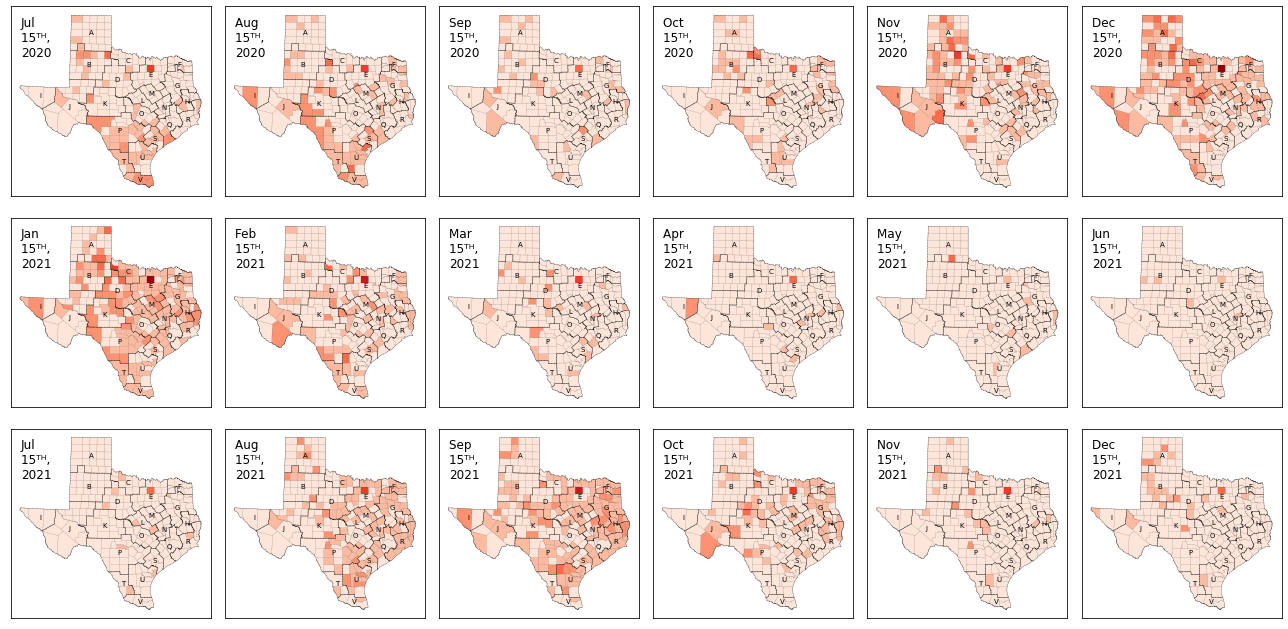

In [56]:
# Define color map
color_brewer = ['#fee5d9','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#99000d']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=7)

fig, axes = plt.subplots(3, 6, figsize=(18,9))
ax = axes.reshape(-1)

for idx, m in enumerate(period):
    print(m)
    ave_mortality.plot(column=m, 
                       ax = ax[idx],
                       cmap=cm,
                       scheme='user_defined',
                       classification_kwds={'bins':map_class_mortality.bins} # then speicfy class here.
                      )
    tsa_boundary.boundary.plot(ax=ax[idx], lw=0.3, color='black', linestyle='dashed')
    county_boundary.boundary.plot(ax=ax[idx], lw=0.15, color='black', linestyle='dotted')
    
    for idx_1, row in tsa_boundary.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
        ax[idx].text(s=idx_1, # String to be displayed; TSA name
                     x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
                     y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label            
                     fontsize=7, 
                     color='black',
                     ha='center', # Horizontal align
                     va='center', # Vertical align
#                      path_effects=[pe.withStroke(linewidth=1, foreground="white")] # This will create boundary of text
                    )
    

#     ax[idx].set_title(m)
    month_text = datetime.datetime.strptime(m, '%m/%d/%Y')
    month_text = month_text.strftime('%b \n15ᵀᴴ, \n%Y')
    ax[idx].text(0.05, 0.95, s=month_text, fontsize=12, ha='left', va='top', transform=ax[idx].transAxes)
    ax[idx].get_xaxis().set_visible(False)
    ax[idx].get_yaxis().set_visible(False)
    
plt.tight_layout() # Will shrink empty area
plt.show()

## Start from here

## Correlation between Accessibility and Mortality

In [64]:
# Spatial accessibility
access_county = gpd.read_file("./data/processed_data/ICU_access_measures/ICU_access_county.shp")
# access_county = access_county.set_index('NAME')
access_county.head(1)

,index,NAME,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,...,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,geometry
0,48327,Menard,0.48145,0.504673,0.494921,0.359804,0.380861,0.416848,0.445366,0.463968,...,0.057078,0.055447,0.057775,0.058969,0.056747,0.050579,0.046795,0.044798,0.042296,"POLYGON ((-99.77120 30.71079, -99.78240 30.710..."


In [65]:
import warnings
warnings.filterwarnings("ignore")


pearson_dict = dict()
no_access_county = list()

for idx, row in tsa.iterrows():
    acc_ts = access_county.loc[access_county['NAME'] == row['County'], focus_date].values[0]
    death_ts = ave_mortality.loc[ave_mortality['NAME'] == row['County'], focus_date].values[0]
    pearr, pearp = pearsonr(acc_ts, death_ts)
    
    pearson_dict[row['FIPS']] = dict()
    if pearr is np.nan:
        pearson_dict[row['FIPS']]["coef"] = np.nan
        pearson_dict[row['FIPS']]["pval"] = np.nan
        pearson_dict[row['FIPS']]["notes"] = 'no access'
    
    else:
        
        if pearp < 0.05:
        
            pearson_dict[row['FIPS']]["coef"] = pearr
            pearson_dict[row['FIPS']]["pval"] = pearp
            pearson_dict[row['FIPS']]["notes"] = 'valid'
        
        else:
            pearson_dict[row['FIPS']]["coef"] = pearr
            pearson_dict[row['FIPS']]["pval"] = pearp
            pearson_dict[row['FIPS']]["notes"] = 'invalid'

    
coefs = [pearson_dict[ind]["coef"] for ind in tsa["FIPS"]]
pvals = [pearson_dict[ind]["pval"] for ind in tsa["FIPS"]]
notes = [pearson_dict[ind]["notes"] for ind in tsa["FIPS"]]

# Convert Dictionary to DataFrame
pearson_df = pd.DataFrame({"FIPS": tsa["FIPS"], "coefs": coefs, "pvals": pvals, "notes": notes})
pearson_df['FIPS'] = pearson_df['FIPS'].astype(str)

pearson_df.head()

,FIPS,coefs,pvals,notes
0,48011,-0.120526,4.685506e-03,valid
1,48045,-0.079491,6.271066e-02,invalid
2,48065,-0.411368,7.826803e-24,valid
3,48075,-0.322874,8.721013e-15,valid
4,48087,-0.257040,9.845750e-10,valid


In [66]:
pearson_gdf = county_boundary.merge(pearson_df, left_on='index', right_on='FIPS')
pearson_gdf

,geometry,FIPS,coefs,pvals,notes
0,"POLYGON ((1021871.185 949587.707, 1020800.195 ...",48327,-0.190695,6.818081e-06,valid
1,"POLYGON ((839565.549 1295933.898, 839563.330 1...",48189,-0.371250,2.205194e-19,valid
2,"POLYGON ((900765.850 1428038.686, 900763.557 1...",48011,-0.120526,4.685506e-03,valid
3,"POLYGON ((1356653.608 711857.888, 1356643.348 ...",48057,-0.172739,4.725721e-05,valid
4,"POLYGON ((1187010.199 1294781.054, 1187011.360...",48077,-0.345603,7.583393e-17,valid
...,...,...,...,...,...
249,"POLYGON ((790727.893 1543933.853, 790953.597 1...",48205,-0.103045,1.572056e-02,valid
250,"POLYGON ((1203375.980 635917.280, 1203376.325 ...",48249,-0.451897,5.533290e-29,valid
251,"POLYGON ((1083961.136 569160.648, 1084088.878 ...",48505,-0.056408,1.869276e-01,invalid
252,"POLYGON ((1214194.016 920929.687, 1214221.436 ...",48453,-0.619648,1.572491e-59,valid


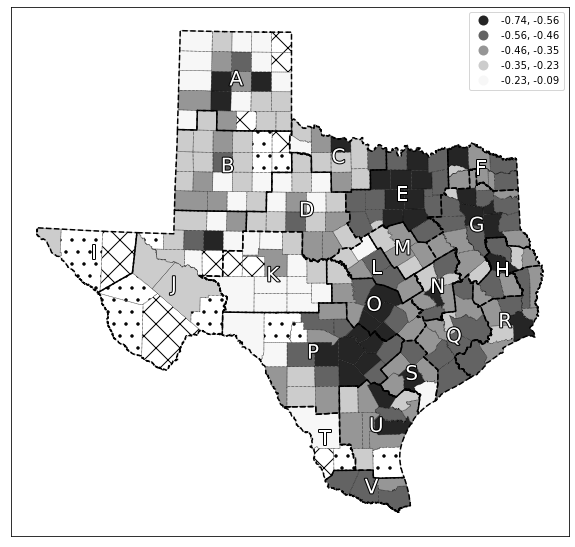

In [67]:
# Define color map
color_brewer = ['#f7f7f7','#cccccc','#969696','#636363','#252525']
color_brewer.reverse()
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=5)

fig, ax = plt.subplots(figsize=(10,10))

pearson_gdf.loc[pearson_gdf['notes'] == 'valid'].plot('coefs', ax=ax, scheme='fisher_jenks', cmap=cm, legend=True)
pearson_gdf.loc[pearson_gdf['notes'] == 'invalid'].plot(ax=ax, hatch='X', color='white')  # Locations with insignificant pearsonr correlation
pearson_gdf.loc[pearson_gdf['notes'] == 'no access'].plot(ax=ax, hatch='.', color='white')  # Locations without access to icu beds

county.boundary.plot(color='black', 
                     linewidth=0.5, 
                     linestyle='dotted', 
                     ax=ax
                    )

tsa_boundary.boundary.plot(color='black', 
                     linewidth=1.5, 
                     linestyle='dashed', 
                     ax=ax)

for idx, row in tsa_boundary.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
    ax.text(s=idx, # String to be displayed; TSA name
            x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
            y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label
            fontsize=20, 
            color='white',
            ha='center', # Horizontal align
            va='center', # Vertical align
            path_effects=[pe.withStroke(linewidth=2, foreground="black")] # This will create boundary of text
           )

ax.get_xaxis().set_visible(False)  # Remove ticks and labels
ax.get_yaxis().set_visible(False)

In [68]:
def normalize(ary):
    ary_ = ary.copy()
    ary_ = ary_.astype('float64')
    
    for idx, val in enumerate(ary):
        ary_[idx] = (val - ary.min()) / (ary.max() - ary.min())
        
    return ary_

0 Harris
1 Dallas
2 Tarrant
3 Bexar
4 Travis
5 El Paso


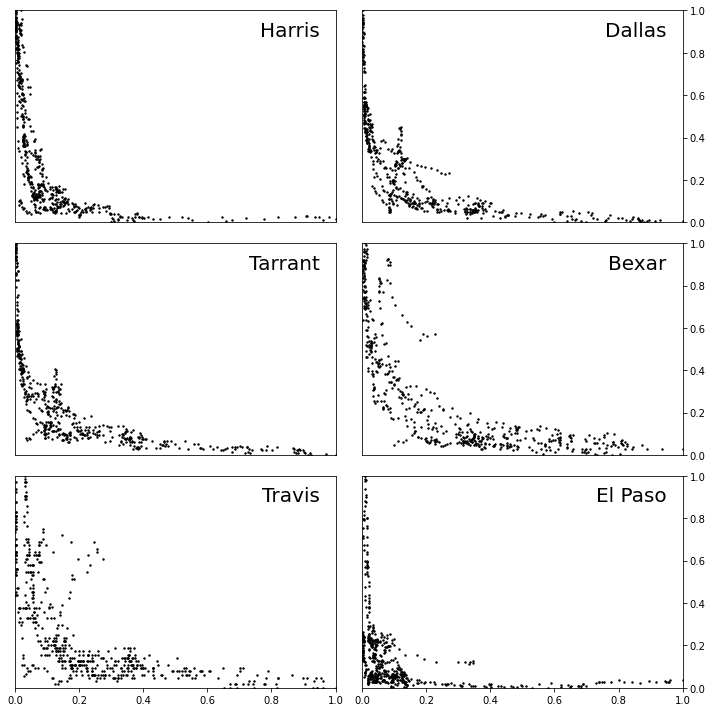

In [71]:
county_names = {'Harris': '48201', # Houston
                'Dallas': '48113', # Dallas
                'Tarrant': '48439', # Fort Worth
                'Bexar': '48029', # San Antonio
                'Travis': '48453', # Austin
                'El Paso': '48141'
               }

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes_ = axes.reshape(-1)

for idx, county_name in enumerate(county_names.keys()):
    print(idx, county_name)
    
    acc_ts = access_county.loc[access_county['NAME']==county_name, focus_date].values
    death_ts = ave_mortality.loc[ave_mortality['NAME']==county_name, focus_date].values
    
    acc_ts_ = normalize(acc_ts)
    death_ts_ = normalize(death_ts)
    
    axes_[idx].scatter(acc_ts_, death_ts_, color='black', s=2)
    axes_[idx].set_xlim(0, 1)
    axes_[idx].set_ylim(0, 1)
    
    axes_[idx].text(0.95, 0.95, county_name, fontsize=20, ha='right', va='top', transform=axes_[idx].transAxes)
    
    axes_[idx].yaxis.tick_right()
    if idx %2 == 0:
        axes_[idx].get_yaxis().set_visible(False)
    if idx < 4 :
        axes_[idx].get_xaxis().set_visible(False)  # Remove ticks and labels
        
plt.tight_layout() # Will shrink empty area
plt.show()


## Correlation at TSA level

In [118]:
# Create TSA Geometry
access_tsa = access_county[['index', 'geometry']].copy(deep=True)
access_tsa = access_tsa.merge(tsa, left_on='index', right_on='FIPS')
access_tsa = access_tsa.drop(columns=['index', 'FIPS', 'County'])
access_tsa = access_tsa.dissolve(by='TSA')

ave_mortality_tsa = access_tsa.copy(deep=True)

tsa_list = tsa['TSA'].unique().tolist()
tsa_list.sort()
tsa_list

for date in tqdm(focus_date):
    
    access_tsa[date] = 0.0
    for t_tsa in tsa_list:
        
        # List of counties in each TSA
        t_fips = pop.loc[pop['TSA'] == t_tsa, 'FIPS'].tolist()
        t_county_access = access_county.loc[access_county['index'].isin(t_fips), date] # Accessbility per county
        t_county_pop = pop.loc[pop['FIPS'].isin(t_fips), 'pop'] # Population per county

        t_tsa_pop = pop.loc[pop['FIPS'].isin(t_fips), 'pop'].sum() # Total poppulation in each TSA
        t_tsa_access = sum(t_county_pop.values * t_county_access.values) / t_tsa_pop # Estimate of accessibility per TSA

        t_ave_death_tsa = ave_death_tsa.loc[t_tsa, date]  # 7-days Averaged COVID-19 death per TSA per each day
        t_ave_mortality_tsa = t_ave_death_tsa / t_tsa_pop * 100000  # 7-days Averaged COVID-19 mortality per 100,000 people per TSA per each day
        
        access_tsa.at[t_tsa, date] = t_tsa_access
        ave_mortality_tsa.at[t_tsa, date] = t_ave_mortality_tsa
        
access_tsa.head(3)

100%|███████████████████████████████████| 549/549 [00:12<00:00, 42.75it/s]


,geometry,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
TSA,,,,,,,,,,,,,,,,,,,,,
A,"POLYGON ((-102.52531 34.50009, -102.52583 34.4...",0.102964,0.101861,0.099365,0.105888,0.106406,0.110394,0.103770,0.102255,0.074615,...,0.002729,0.002846,0.003019,0.003267,0.003630,0.003534,0.003236,0.003230,0.003185,0.002659
B,"POLYGON ((-102.20607 32.52326, -102.20979 32.5...",0.197540,0.174825,0.139550,0.124652,0.122717,0.113249,0.094828,0.080678,0.071264,...,0.008306,0.007768,0.007016,0.006437,0.005844,0.004843,0.005034,0.004720,0.004492,0.003857
C,"POLYGON ((-97.97646 33.88846, -97.97426 33.886...",0.183654,0.182702,0.177227,0.175725,0.172783,0.168848,0.155128,0.157163,0.148219,...,0.019902,0.020424,0.020923,0.020517,0.020090,0.020018,0.016279,0.014635,0.014034,0.010452


In [125]:
ave_mortality_tsa.head(1)

,geometry,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
TSA,,,,,,,,,,,,,,,,,,,,,
A,"POLYGON ((-102.52531 34.50009, -102.52583 34.4...",5.489346,5.465987,5.528278,5.205702,5.63951,5.70625,6.173429,6.407018,6.573867,...,1.201316,1.167946,1.334795,1.401535,1.368165,1.434905,1.334795,1.362604,1.448253,1.226343


In [126]:
ave_case_tsa.head(1)

,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,07/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
TSA,,,,,,,,,,,,,,,,,,,,,
A,727.75,744.8,780.166667,804.857143,875.571429,847.142857,852.428571,871.428571,896.428571,955.285714,...,964.571429,1023.714286,1155.0,1203.0,1239.857143,1244.0,1249.142857,1198.0,1247.4,1145.0


In [127]:
access_tsa.head(1)

,geometry,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
TSA,,,,,,,,,,,,,,,,,,,,,
A,"POLYGON ((-102.52531 34.50009, -102.52583 34.4...",0.102964,0.101861,0.099365,0.105888,0.106406,0.110394,0.10377,0.102255,0.074615,...,0.002729,0.002846,0.003019,0.003267,0.00363,0.003534,0.003236,0.00323,0.003185,0.002659


In [129]:
icu_empty_ratio.head(1)

,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,07/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
A,0.264151,0.260786,0.256238,0.256262,0.256783,0.261419,0.264535,0.260488,0.256133,0.248269,...,0.07911,0.081352,0.086207,0.087331,0.091352,0.085749,0.081535,0.080668,0.079602,0.066946


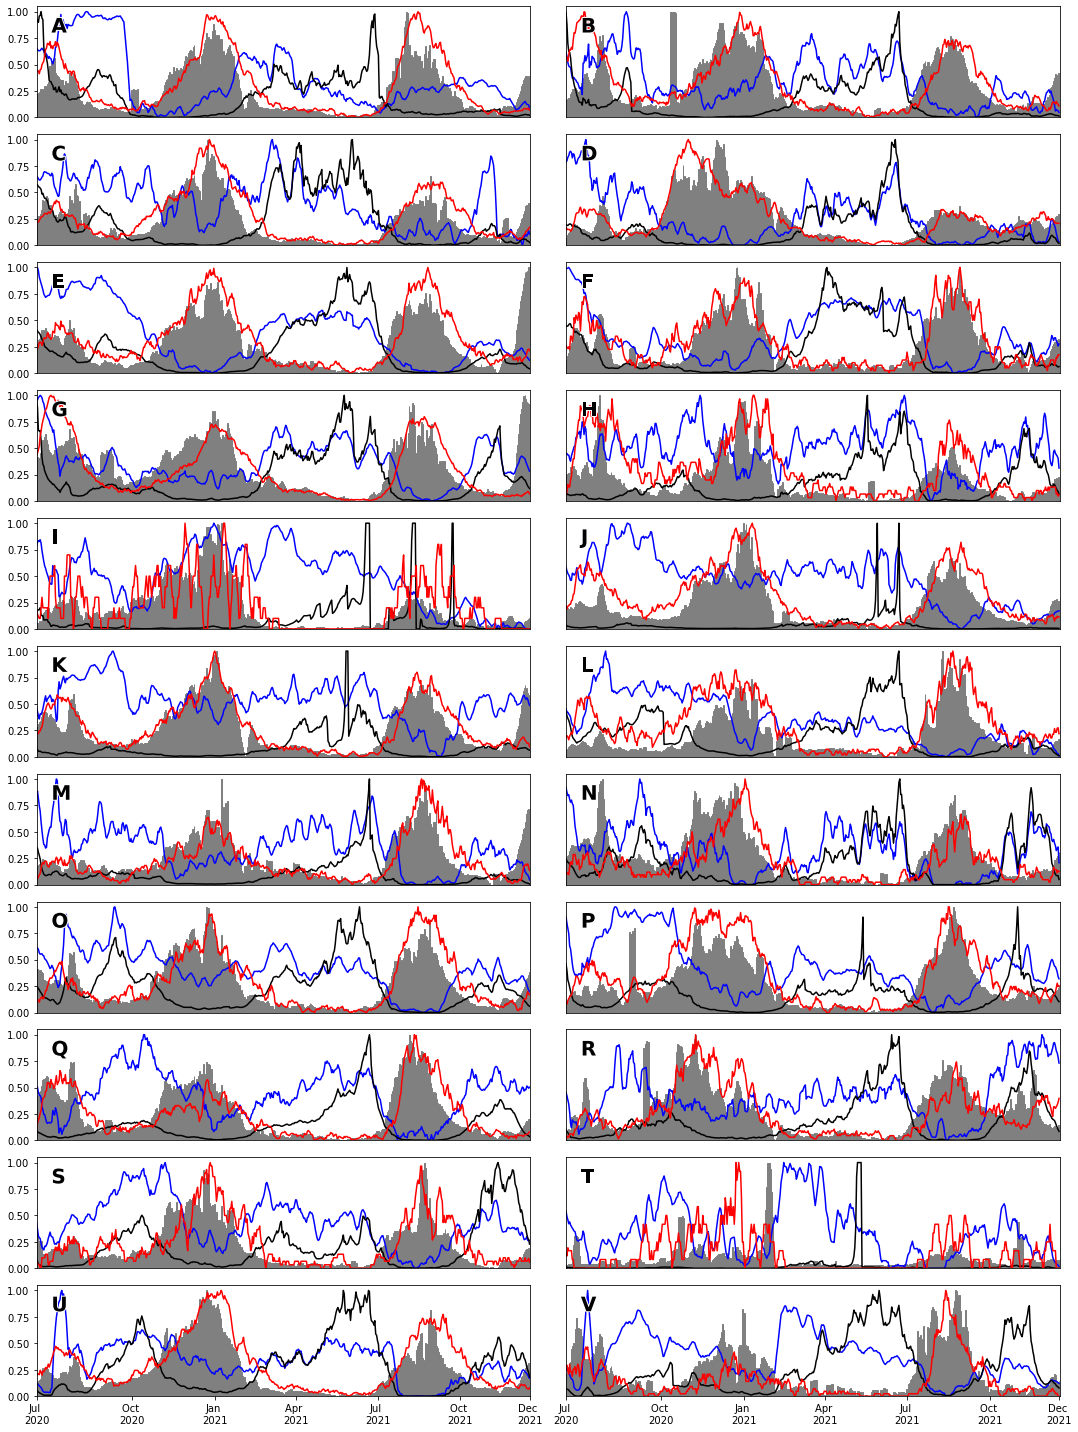

In [159]:
# Plot the trend per TSA
tsa_list = tsa['TSA'].unique().tolist()
tsa_list.sort()
tsa_list

period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]

plot_period = ['07/01/2020', '10/15/2020', '01/15/2021', '04/15/2021', '07/15/2021', '10/15/2021', '12/31/2021']

fig, axes = plt.subplots(11, 2, figsize=(15, 20))

for idx, t_tsa in enumerate(tsa_list):
    ax = axes.reshape(-1)[idx]
    
    icu_ts = icu_empty_ratio.loc[icu_empty_ratio.index == t_tsa, focus_date].values[0]
    icu_ts = normalize(icu_ts)
    ax.plot(focus_date, icu_ts, label='ICU', color='blue')
    
    acc_ts = access_tsa.loc[access_tsa.index == t_tsa, focus_date].values[0]
    acc_ts[acc_ts > 1] = 1
    acc_ts = normalize(acc_ts)
    ax.plot(focus_date, acc_ts, label='Access', color='black')
    
    case_ts = ave_case_tsa.loc[ave_case_tsa.index == t_tsa, focus_date].values[0]
    case_ts = normalize(case_ts)
    ax.bar(focus_date, case_ts, label='Case', width=1.0, facecolor='grey', edgecolor='grey')
    
    death_ts = ave_mortality_tsa.loc[ave_mortality_tsa.index == t_tsa, focus_date].values[0]
    death_ts = normalize(death_ts)
    ax.plot(focus_date, death_ts, label='Death', color='red')
    
    ax.text(0.03, 
            0.9, 
            t_tsa, 
            fontsize=20, 
            ha='left', 
            va='top', 
            transform=ax.transAxes, 
            weight='bold',
            path_effects=[pe.withStroke(linewidth=2, foreground="white")] # This will create boundary of text
           )
    
    ax.set_xlim(0, len(focus_date))
    
    if idx <= 19:
        ax.get_xaxis().set_visible(False)
        
    else:
        ax.set_xticks([focus_date.index(val) for val in plot_period]) # The locations that ticks will be displayed.
        ax.set_xticklabels([datetime.datetime.strptime(val, '%m/%d/%Y').strftime('%b \n%Y') for val in plot_period])
        
        
    if idx % 2 != 0:
        ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()